# TikTok Hackathon Challenge 2023

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ast
import pprint

## Section 1: Exploratory Data Analysis

In [3]:
# Read the given csv
ads_data = pd.read_csv('ads.csv')
moderators_data = pd.read_csv('moderators.csv')

In [4]:
# Detailed summary of the ads data
ads_data_summary = {
    "Number of Rows": ads_data.shape[0],
    "Number of Columns": ads_data.shape[1],
    "Column Names": list(ads_data.columns),
    "Missing Values": ads_data.isnull().sum().to_dict(),
    "Data Types": ads_data.dtypes.to_dict(),
    "Unique Values": {col: ads_data[col].nunique() for col in ads_data.columns},
    "Top 5 Rows": ads_data.head()
}

pprint.pprint(ads_data_summary)

{'Column Names': ['p_date',
                  'ad_id',
                  'delivery_country',
                  'queue_market',
                  'punish_num',
                  'latest_punish_begin_date',
                  'ad_revenue',
                  'avg_ad_revenue',
                  'start_time',
                  'baseline_st',
                  'product_line',
                  'task_type_en'],
 'Data Types': {'ad_id': dtype('int64'),
                'ad_revenue': dtype('float64'),
                'avg_ad_revenue': dtype('float64'),
                'baseline_st': dtype('float64'),
                'delivery_country': dtype('O'),
                'latest_punish_begin_date': dtype('O'),
                'p_date': dtype('int64'),
                'product_line': dtype('O'),
                'punish_num': dtype('float64'),
                'queue_market': dtype('O'),
                'start_time': dtype('O'),
                'task_type_en': dtype('O')},
 'Missing Values': {'ad_id': 0,
  

### Investigating duplicate ad_ids

In [5]:
# Find the duplicate ad_ids
duplicate_ad_ids = ads_data[ads_data.duplicated(subset='ad_id', keep=False)]

# Getting the frequency of these duplicates
duplicate_ad_ids_frequency = duplicate_ad_ids['ad_id'].value_counts()

# Getting a few rows with duplicate ad_id values to examine
sample_duplicate_rows = duplicate_ad_ids[duplicate_ad_ids['ad_id'].isin(duplicate_ad_ids_frequency.index[:5])]

{
    "Number of Duplicate ad_ids": duplicate_ad_ids_frequency.shape[0],
    "Frequency of Top 5 Duplicate ad_ids": duplicate_ad_ids_frequency.head().to_dict(),
    "Sample Rows with Duplicate ad_ids": sample_duplicate_rows
}
 

{'Number of Duplicate ad_ids': 2022,
 'Frequency of Top 5 Duplicate ad_ids': {1773564011076700: 46,
  1773572194078750: 41,
  1773529954701310: 40,
  1773207852741640: 39,
  1767594840576010: 39},
 'Sample Rows with Duplicate ad_ids':          p_date             ad_id delivery_country queue_market  punish_num  \
 1843   20230807  1773572194078750               IQ       Others         1.0   
 1844   20230807  1773572194078750               ZA           ZA         1.0   
 1845   20230807  1773572194078750               PL           PL         1.0   
 1846   20230807  1773572194078750               IL           IL         1.0   
 1847   20230807  1773572194078750               BE           BE         1.0   
 ...         ...               ...              ...          ...         ...   
 26190  20230807  1773564011076700               IQ       Others         NaN   
 26191  20230807  1773564011076700               BE           BE         NaN   
 26192  20230807  1773564011076700            

Even though ad_id is the same, other columns have different values, which possibly suggests that each row represents different aspects of the same ad campaign, denoting different target markets or product lines. Hence the ad_id duplicates should not be a concern.

### Reformatting p_date and start_time

In [6]:
# Convert p_date to datetime format (YYYY-MM-DD)
ads_data['p_date'] = pd.to_datetime(ads_data['p_date'], format='%Y%m%d')

# Convert start_time to datetime format (but keeping the date part as it is, since it is not in a standard format)
ads_data['start_time'] = pd.to_datetime(ads_data['start_time'], errors='coerce', format='%d/%m/%y %H:%M')

# Shift 'start_time' to the second column position for easier comparison with 'p_date'
column_order = ['p_date', 'start_time'] + [col for col in ads_data if col not in ['p_date', 'start_time']]
ads_data = ads_data[column_order]

# Displaying the first few rows of the modified dataset
ads_data.head()


,p_date,start_time,ad_id,delivery_country,queue_market,punish_num,latest_punish_begin_date,ad_revenue,avg_ad_revenue,baseline_st,product_line,task_type_en
0,2023-08-07,2022-10-24 14:36:00,1747578422390810,US,USCA,1.0,24/7/23,5132.1700,4795.250,1.78,Auction Ads,auction_relation
1,2023-08-07,2023-02-22 15:50:00,1758543228094480,SA,MENA,1.0,14/6/23,1976.2500,1063.767,1.67,RIE,Ad Group Recall (Merged)
2,2023-08-07,2022-07-14 05:00:00,1738303151826990,AU,AU,2.0,24/7/23,1.7355,5.365,1.84,Auction Ads,auction_relation
3,2023-08-07,2022-07-14 05:16:00,1738303920938010,NZ,NZ,2.0,24/7/23,NaN,5.365,1.58,Auction Ads,auction_relation
4,2023-08-07,2022-07-14 05:17:00,1738304016410620,NZ,NZ,2.0,24/7/23,1.5250,5.365,1.58,Auction Ads,auction_relation


In [7]:
# Filtering the dataset for start_time on or after 2023-08-08
filtered_data_20230808 = ads_data[ads_data['start_time'] >= '2023-08-08']

# Checking if there are any rows where ad_revenue is greater than 0 in the filtered dataset
non_zero_ad_revenue_rows = filtered_data_20230808[filtered_data_20230808['ad_revenue'] > 0]

# Getting the total number of rows in the filtered dataset and the number of rows where ad_revenue is greater than 0
total_rows_20230808 = filtered_data_20230808.shape[0]
rows_with_ad_revenue_greater_than_zero_20230808 = non_zero_ad_revenue_rows.shape[0]

{
    "Total Rows (start_time >= 2023-08-08)": total_rows_20230808,
    "Rows with Ad Revenue > 0": rows_with_ad_revenue_greater_than_zero_20230808,
}


{'Total Rows (start_time >= 2023-08-08)': 658, 'Rows with Ad Revenue > 0': 0}

### Exploring ads that are currently running

In [8]:
# Filtering data for start_time on or before 2023-08-07
data_before_20230808 = ads_data[ads_data['start_time'] <= '2023-08-07']

# Segmenting the data into ads from punished and non-punished advertisers
# Ads from punished advertisers (punish_num > 0)
ads_from_punished_advertisers = data_before_20230808[data_before_20230808['punish_num'] > 0]

# Ads from non-punished advertisers (punish_num is NaN)
ads_from_non_punished_advertisers = data_before_20230808[data_before_20230808['punish_num'].isna()]

ads_from_punished_advertisers.describe(), ads_from_non_punished_advertisers.describe()

(                    p_date                     start_time         ad_id  \
 count                 1056                           1056  1.056000e+03   
 mean   2023-08-07 00:00:00  2023-07-23 18:31:25.909091072  1.772232e+15   
 min    2023-08-07 00:00:00            2022-02-10 14:07:00  1.724386e+15   
 25%    2023-08-07 00:00:00            2023-07-28 09:45:00  1.772620e+15   
 50%    2023-08-07 00:00:00            2023-08-06 03:54:30  1.773432e+15   
 75%    2023-08-07 00:00:00            2023-08-06 12:09:00  1.773482e+15   
 max    2023-08-07 00:00:00            2023-08-06 23:49:00  1.773534e+15   
 std                    NaN                            NaN  3.674187e+12   
 
         punish_num   ad_revenue  avg_ad_revenue  baseline_st  
 count  1056.000000   744.000000     1056.000000  1056.000000  
 mean      1.254735    91.910859       27.205353     1.854375  
 min       1.000000     0.000000        0.000000     0.540000  
 25%       1.000000     2.200000        3.201000     1.620

### Explore distribution of 'risky' and 'non-risky' ads that are currently running

### Exploring moderator data

In [9]:
moderators_data

,moderator,market,Productivity,Utilisation %,handling time,accuracy
0,1689841547143170,"[""SA"", ""OM"", ""BH"", ""QA"", ""JO"", ""IQ"", ""KW"", ""EG...",286.217674,0.812403,123549,-
1,1686755036370945,"[""RO""]",174.560000,0.704833,25547,0.959
2,1741913197768705,"[""VN""]",334.376000,0.819167,50794,1.000
3,1743415203890193,"[""MX"", ""UY"", ""CL"", ""AR"", ""CO"", ""EC"", ""PE"", ""BR""]",452.277500,0.775474,89626,0.941
4,1710346282427393,"[""PH""]",612.312500,0.843229,98066,0.887
...,...,...,...,...,...,...
1409,1734911746733057,"[""US"", ""CA""]",180.750000,0.685469,79210,0.860
1410,1694737747315714,"[""TH""]",542.360000,0.890927,49664,0.958
1411,1730993346971650,"[""RO""]",320.960000,0.843042,73769,0.967
1412,1707706649725953,"[""GB""]",283.261333,0.846072,90975,0.865


In [10]:
# Moderators data statistics
moderators_data.describe()

,moderator,Productivity,Utilisation %,handling time
count,1.414000e+03,1285.000000,1285.000000,1.414000e+03
mean,1.073880e+15,366.484054,0.722875,9.681603e+04
std,8.371512e+14,178.657826,0.197442,3.572110e+05
min,1.003316e+06,0.540000,0.000000,0.000000e+00
25%,6.955122e+06,247.033333,0.654746,4.913700e+04
50%,1.695067e+15,343.585000,0.779014,8.135100e+04
75%,1.736353e+15,461.167500,0.849486,1.000525e+05
max,1.774284e+15,1323.355000,1.287250,9.443621e+06


In [11]:
# Cleaning the 'accuracy' column and converting it to a numerical data type
moderators_data['accuracy'] = pd.to_numeric(moderators_data['  accuracy  '].str.strip().replace('-', np.nan))
moderators_data.drop(columns=['  accuracy  '], inplace=True)
moderators_data

,moderator,market,Productivity,Utilisation %,handling time,accuracy
0,1689841547143170,"[""SA"", ""OM"", ""BH"", ""QA"", ""JO"", ""IQ"", ""KW"", ""EG...",286.217674,0.812403,123549,NaN
1,1686755036370945,"[""RO""]",174.560000,0.704833,25547,0.959
2,1741913197768705,"[""VN""]",334.376000,0.819167,50794,1.000
3,1743415203890193,"[""MX"", ""UY"", ""CL"", ""AR"", ""CO"", ""EC"", ""PE"", ""BR""]",452.277500,0.775474,89626,0.941
4,1710346282427393,"[""PH""]",612.312500,0.843229,98066,0.887
...,...,...,...,...,...,...
1409,1734911746733057,"[""US"", ""CA""]",180.750000,0.685469,79210,0.860
1410,1694737747315714,"[""TH""]",542.360000,0.890927,49664,0.958
1411,1730993346971650,"[""RO""]",320.960000,0.843042,73769,0.967
1412,1707706649725953,"[""GB""]",283.261333,0.846072,90975,0.865


### Check duplicates

In [12]:
# Checking for duplicate moderator IDs
duplicate_moderator_ids = moderators_data['moderator'].duplicated().sum()
unique_moderator_ids = moderators_data['moderator'].nunique()
duplicate_moderator_ids, unique_moderator_ids

(0, 1414)

### Investigate missing data/anomalies

In [13]:
# Identifying missing values in the "Productivity", "Utilisation %" and "accuracy" columns
missing_values_moderators = moderators_data.isnull().sum()
missing_values_moderators

moderator          0
market             0
Productivity     129
Utilisation %    129
handling time      0
accuracy          11
dtype: int64

In [14]:
# Counting the number of instances where the "handling time" is zero
handling_time_zero_count = (moderators_data['handling time'] == 0).sum()
handling_time_zero_count

129

In [15]:
# Creating a dataframe with potential anomalies (missing values or handling time is 0)
moderator_anomaly_data = moderators_data[
    moderators_data['Productivity'].isnull() | 
    moderators_data['Utilisation %'].isnull() | 
    moderators_data['accuracy'].isnull() | 
    (moderators_data['handling time'] == 0)
]

moderator_clean_data = moderators_data.dropna().loc[moderators_data['handling time'] != 0]

In [16]:
moderator_clean_data.describe()


,moderator,Productivity,Utilisation %,handling time,accuracy
count,1.275000e+03,1275.000000,1275.000000,1.275000e+03,1275.000000
mean,1.084096e+15,368.445545,0.725055,1.068949e+05,0.855468
std,8.345996e+14,177.840831,0.195460,3.747668e+05,0.119057
min,1.003316e+06,0.540000,0.000000,7.300000e+01,0.250000
25%,7.064704e+06,249.239693,0.658732,6.276050e+04,0.799500
50%,1.695291e+15,344.712500,0.779906,8.586800e+04,0.894000
75%,1.736353e+15,462.375000,0.849611,1.016235e+05,0.939000
max,1.774284e+15,1323.355000,1.287250,9.443621e+06,1.000000


In [17]:
moderator_anomaly_data

,moderator,market,Productivity,Utilisation %,handling time,accuracy
0,1689841547143170,"[""SA"", ""OM"", ""BH"", ""QA"", ""JO"", ""IQ"", ""KW"", ""EG...",286.217674,0.812403,123549,NaN
16,1312666,"[""SA"", ""OM"", ""BH"", ""QA"", ""AE"", ""DZ"", ""JO"", ""IQ...",NaN,NaN,0,0.719
22,2735217,"[""VN""]",NaN,NaN,0,0.763
28,1671850168837125,"[""SA"", ""BH"", ""OM"", ""QA"", ""JO"", ""IQ"", ""KW"", ""LB...",NaN,NaN,0,0.869
47,8902072,"[""JP""]",NaN,NaN,0,0.967
...,...,...,...,...,...,...
1393,1695027913818113,"[""IT""]",147.020000,0.335302,25186,NaN
1398,1739949027608577,"[""PL""]",NaN,NaN,0,0.916
1402,1743478384979986,"[""FI""]",NaN,NaN,0,1.000
1404,1762882575703090,"[""BR""]",NaN,NaN,0,0.608


In [18]:
moderator_clean_data

,moderator,market,Productivity,Utilisation %,handling time,accuracy
1,1686755036370945,"[""RO""]",174.560000,0.704833,25547,0.959
2,1741913197768705,"[""VN""]",334.376000,0.819167,50794,1.000
3,1743415203890193,"[""MX"", ""UY"", ""CL"", ""AR"", ""CO"", ""EC"", ""PE"", ""BR""]",452.277500,0.775474,89626,0.941
4,1710346282427393,"[""PH""]",612.312500,0.843229,98066,0.887
5,1748544247125010,"[""MX"", ""UY"", ""CO"", ""CL"", ""AR"", ""EC"", ""PE"", ""BR""]",292.330000,0.678776,80656,0.739
...,...,...,...,...,...,...
1408,1694281660376066,"[""TR""]",273.432381,0.861444,64710,0.943
1409,1734911746733057,"[""US"", ""CA""]",180.750000,0.685469,79210,0.860
1410,1694737747315714,"[""TH""]",542.360000,0.890927,49664,0.958
1411,1730993346971650,"[""RO""]",320.960000,0.843042,73769,0.967


### Exploring distribution of (clean) moderator data

c:\Users\jeane\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\jeane\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\jeane\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\jeane\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na opti

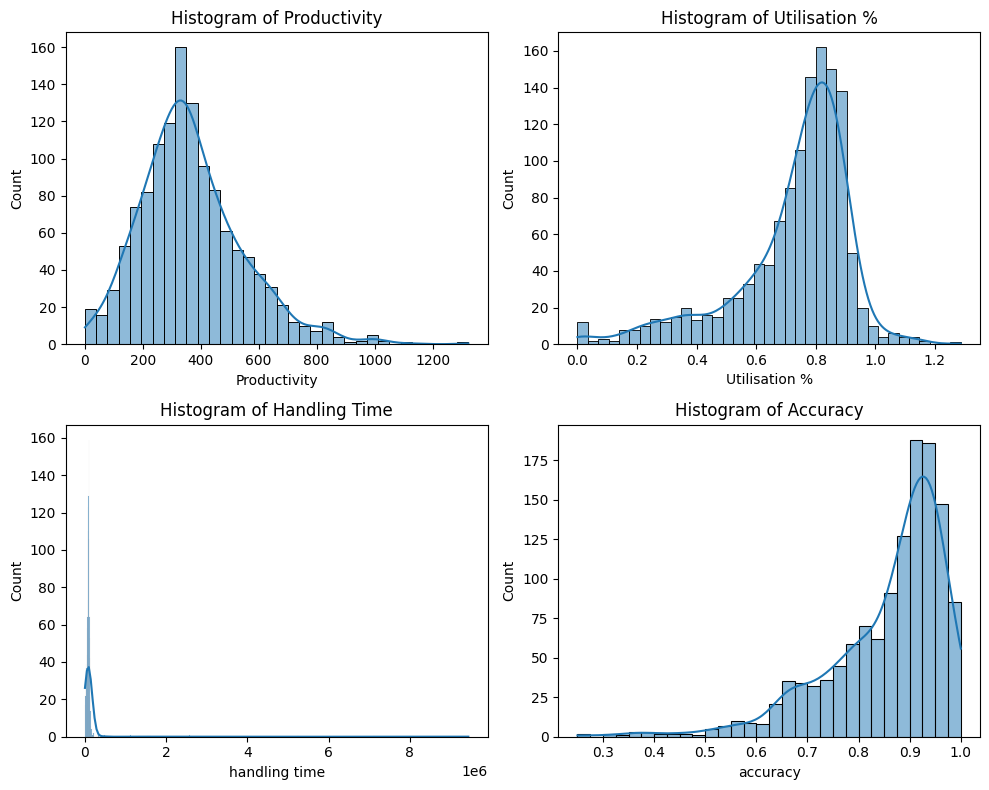

ValueError: could not convert string to float: '["RO"]'

In [19]:
# Visualising the distribution of the numerical columns
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 8))

# Plotting histograms for all numerical columns
sns.histplot(moderator_clean_data['Productivity'], kde=True, ax=axes[0, 0])
sns.histplot(moderator_clean_data['Utilisation %'], kde=True, ax=axes[0, 1])
sns.histplot(moderator_clean_data['handling time'], kde=True, ax=axes[1, 0])
sns.histplot(moderator_clean_data['accuracy'], kde=True, ax=axes[1, 1])

# Setting titles for histograms
axes[0, 0].set_title('Histogram of Productivity')
axes[0, 1].set_title('Histogram of Utilisation %')
axes[1, 0].set_title('Histogram of Handling Time')
axes[1, 1].set_title('Histogram of Accuracy')

# Adjusting layout for histograms
plt.tight_layout()

# Displaying the histograms
plt.show()


# Calculating the correlation between all numerical columns
correlation_analysis_moderator = moderator_clean_data.corr()
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_analysis_moderator, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Heatmap')
plt.show()


### Exploring the anomalous moderator data

In [21]:
# Generating descriptive statistics for the anomaly dataset (df_moderator_anomaly)
moderator_anomaly_data.describe()

,moderator,Productivity,Utilisation %,handling time,accuracy
count,1.390000e+02,10.000000,10.000000,139.000000,128.000000
mean,9.801711e+14,116.393930,0.444872,4366.273381,0.834234
std,8.575964e+14,81.576491,0.258850,18525.792640,0.149708
min,1.005827e+06,26.285000,0.077645,0.000000,0.333000
25%,5.634472e+06,53.936440,0.272986,0.000000,0.758500
50%,1.690697e+15,100.093750,0.340990,0.000000,0.889000
75%,1.733316e+15,152.886875,0.696270,0.000000,0.943500
max,1.772302e+15,286.217674,0.812403,123549.000000,1.000000


In general, there are two cases of moderator anomalies:
1. Missing values for productivity and utilisation, and handling time is 0
2. Missing values for accuracy


In [22]:
# Analysing Case 1: Extracting records where 'Productivity' and 'Utilisation %' are missing, and 'handling time' is 0
case_1_df = moderator_anomaly_data[moderator_anomaly_data['Productivity'].isna() & 
                                 moderator_anomaly_data['Utilisation %'].isna() & 
                                 (moderator_anomaly_data['handling time'] == 0)]

case_1_df.describe()

,moderator,Productivity,Utilisation %,handling time,accuracy
count,1.290000e+02,0.0,0.0,129.0,128.000000
mean,1.003120e+15,NaN,NaN,0.0,0.834234
std,8.547964e+14,NaN,NaN,0.0,0.149708
min,1.087262e+06,NaN,NaN,0.0,0.333000
25%,6.251389e+06,NaN,NaN,0.0,0.758500
50%,1.693948e+15,NaN,NaN,0.0,0.889000
75%,1.736488e+15,NaN,NaN,0.0,0.943500
max,1.772302e+15,NaN,NaN,0.0,1.000000


In [23]:
# Analyzing Case 2: Extracting records with missing values in the 'accuracy' column
case_2_df = moderator_anomaly_data[moderator_anomaly_data['accuracy'].isna()]

case_2_df.describe()

,moderator,Productivity,Utilisation %,handling time,accuracy
count,1.100000e+01,10.000000,10.000000,11.000000,0.0
mean,6.219379e+14,116.393930,0.444872,55173.818182,NaN
std,8.631102e+14,81.576491,0.258850,40652.897060,NaN
min,1.005827e+06,26.285000,0.077645,0.000000,NaN
25%,3.047061e+06,53.936440,0.272986,27585.000000,NaN
50%,5.581253e+06,100.093750,0.340990,42022.000000,NaN
75%,1.692199e+15,152.886875,0.696270,89572.000000,NaN
max,1.761892e+15,286.217674,0.812403,123549.000000,NaN


We will have to handle these anomalies in preprocessing.

## Data Preprocessing

### Preparing the ads dataset

In [24]:
# Creating a new dataset with only the necessary columns
df_ads = ads_data[['ad_id', 'delivery_country', 'punish_num', 'avg_ad_revenue']].copy()
df_ads['punish_num'].fillna(0, inplace=True)

### Feature scaling

In [25]:
# Applying Min-Max scaling to the 'punish_num' and 'avg_ad_revenue' columns
min_punish_num = df_ads['punish_num'].min()
max_punish_num = df_ads['punish_num'].max()
min_avg_ad_revenue = df_ads['avg_ad_revenue'].min()
max_avg_ad_revenue = df_ads['avg_ad_revenue'].max()

df_ads['scaled_punish_num'] = (df_ads['punish_num'] - min_punish_num) / (max_punish_num - min_punish_num)
df_ads['scaled_avg_ad_revenue'] = (df_ads['avg_ad_revenue'] - min_avg_ad_revenue) / (max_avg_ad_revenue - min_avg_ad_revenue)

In [26]:
df_ads

,ad_id,delivery_country,punish_num,avg_ad_revenue,scaled_punish_num,scaled_avg_ad_revenue
0,1747578422390810,US,1.0,4795.250,0.0625,0.279696
1,1758543228094480,SA,1.0,1063.767,0.0625,0.062047
2,1738303151826990,AU,2.0,5.365,0.1250,0.000313
3,1738303920938010,NZ,2.0,5.365,0.1250,0.000313
4,1738304016410620,NZ,2.0,5.365,0.1250,0.000313
...,...,...,...,...,...,...
40674,1773472206047230,VN,0.0,0.000,0.0000,0.000000
40675,1773607712030720,BR,0.0,0.000,0.0000,0.000000
40676,1773589699308540,BE,0.0,0.000,0.0000,0.000000
40677,1773530511220730,TR,0.0,0.000,0.0000,0.000000


### Preparing the moderators dataset

One-hot encoding the country codes

In [ ]:
df_moderators = moderators_data.copy()
# Converting string representations of lists to actual lists in the 'market' column
df_moderators['market'] = df_moderators['market'].apply(ast.literal_eval)

# Getting a list of unique country codes across all lists in the 'market' column
unique_country_codes = set(country_code for sublist in df_moderators['market'].tolist() for country_code in sublist)

# One-hot encoding the country codes
for country_code in unique_country_codes:
    df_moderators[f'{country_code}'] = df_moderators['market'].apply(lambda x: 1 if country_code in x else 0)

# Dropping the original 'market' column
df_moderators.drop(columns=['market'], inplace=True)

df_moderators

,moderator,Productivity,Utilisation %,handling time,accuracy,FR,EC,DK,TR,RU,...,KW,JO,LT,PL,HU,MA,NZ,CL,MX,BY
0,1689841547143170,286.217674,0.812403,123549,NaN,0,0,0,0,0,...,1,1,0,0,0,0,0,0,0,0
1,1686755036370945,174.560000,0.704833,25547,0.959,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1741913197768705,334.376000,0.819167,50794,1.000,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1743415203890193,452.277500,0.775474,89626,0.941,0,1,0,0,0,...,0,0,0,0,0,0,0,1,1,0
4,1710346282427393,612.312500,0.843229,98066,0.887,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1409,1734911746733057,180.750000,0.685469,79210,0.860,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1410,1694737747315714,542.360000,0.890927,49664,0.958,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1411,1730993346971650,320.960000,0.843042,73769,0.967,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1412,1707706649725953,283.261333,0.846072,90975,0.865,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
# Creating a dataframe with potential anomalies (missing values or handling time is 0)
df_moderator_anomaly = df_moderators[
    df_moderators['Productivity'].isnull() | 
    df_moderators['Utilisation %'].isnull() | 
    df_moderators['accuracy'].isnull() | 
    (df_moderators['handling time'] == 0)
].copy()

# Creating a clean dataset by removing the anomalies
df_moderator_clean = df_moderators.dropna().loc[df_moderators['handling time'] != 0].copy()


### Inputing data into anomalous set

In [ ]:
# Calculating the median values from the clean dataset
median_productivity = df_moderator_clean['Productivity'].median()
median_utilisation = df_moderator_clean['Utilisation %'].median()
median_handling_time = df_moderator_clean['handling time'].median()
median_accuracy = df_moderator_clean['accuracy'].median()

# Imputing missing or zero values in the anomaly dataset with the respective median values
df_moderator_anomaly['Productivity'].fillna(median_productivity, inplace=True)
df_moderator_anomaly['Utilisation %'].fillna(median_utilisation, inplace=True)
df_moderator_anomaly['handling time'].replace(0, median_handling_time, inplace=True)
df_moderator_anomaly['accuracy'].fillna(median_accuracy, inplace=True)

df_moderator_anomaly

,moderator,Productivity,Utilisation %,handling time,accuracy,FR,EC,DK,TR,RU,...,KW,JO,LT,PL,HU,MA,NZ,CL,MX,BY
0,1689841547143170,286.217674,0.812403,123549,0.894,0,0,0,0,0,...,1,1,0,0,0,0,0,0,0,0
16,1312666,344.712500,0.779906,85868,0.719,0,0,0,0,0,...,1,1,0,0,0,1,0,0,0,0
22,2735217,344.712500,0.779906,85868,0.763,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
28,1671850168837125,344.712500,0.779906,85868,0.869,0,0,0,0,0,...,1,1,0,0,0,0,0,0,0,0
47,8902072,344.712500,0.779906,85868,0.967,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1393,1695027913818113,147.020000,0.335302,25186,0.894,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1398,1739949027608577,344.712500,0.779906,85868,0.916,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
1402,1743478384979986,344.712500,0.779906,85868,1.000,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1404,1762882575703090,344.712500,0.779906,85868,0.608,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Feature scaling

In [ ]:
# For clean dataset
df_moderator_clean.insert(4, 'reciprocal_handling_time', 1 / df_moderator_clean['handling time'])
min_reciprocal_handling_time_clean = df_moderator_clean['reciprocal_handling_time'].min()
max_reciprocal_handling_time_clean = df_moderator_clean['reciprocal_handling_time'].max()
df_moderator_clean['scaled_reciprocal_handling_time'] = (df_moderator_clean['reciprocal_handling_time'] - min_reciprocal_handling_time_clean) / (max_reciprocal_handling_time_clean - min_reciprocal_handling_time_clean)
df_moderator_clean.insert(5, 'scaled_reciprocal_handling_time', df_moderator_clean.pop('scaled_reciprocal_handling_time'))

# For anomaly dataset
df_moderator_anomaly.insert(4, 'reciprocal_handling_time', 1 / df_moderator_anomaly['handling time'])
min_reciprocal_handling_time_anomaly = df_moderator_anomaly['reciprocal_handling_time'].min()
max_reciprocal_handling_time_anomaly = df_moderator_anomaly['reciprocal_handling_time'].max()
df_moderator_anomaly['scaled_reciprocal_handling_time'] = (df_moderator_anomaly['reciprocal_handling_time'] - min_reciprocal_handling_time_anomaly) / (max_reciprocal_handling_time_anomaly - min_reciprocal_handling_time_anomaly)
df_moderator_anomaly.insert(5, 'scaled_reciprocal_handling_time', df_moderator_anomaly.pop('scaled_reciprocal_handling_time'))

In [ ]:
df_moderator_clean

,moderator,Productivity,Utilisation %,handling time,reciprocal_handling_time,scaled_reciprocal_handling_time,accuracy,FR,EC,DK,...,KW,JO,LT,PL,HU,MA,NZ,CL,MX,BY
1,1686755036370945,174.560000,0.704833,25547,0.000039,0.002850,0.959,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1741913197768705,334.376000,0.819167,50794,0.000020,0.001429,1.000,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1743415203890193,452.277500,0.775474,89626,0.000011,0.000807,0.941,0,1,0,...,0,0,0,0,0,0,0,1,1,0
4,1710346282427393,612.312500,0.843229,98066,0.000010,0.000737,0.887,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,1748544247125010,292.330000,0.678776,80656,0.000012,0.000897,0.739,0,1,0,...,0,0,0,0,0,0,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1408,1694281660376066,273.432381,0.861444,64710,0.000015,0.001120,0.943,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1409,1734911746733057,180.750000,0.685469,79210,0.000013,0.000914,0.860,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1410,1694737747315714,542.360000,0.890927,49664,0.000020,0.001462,0.958,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1411,1730993346971650,320.960000,0.843042,73769,0.000014,0.000982,0.967,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
df_moderator_anomaly

,moderator,Productivity,Utilisation %,handling time,reciprocal_handling_time,scaled_reciprocal_handling_time,accuracy,FR,EC,DK,...,KW,JO,LT,PL,HU,MA,NZ,CL,MX,BY
0,1689841547143170,286.217674,0.812403,123549,0.000008,0.000000,0.894,0,0,0,...,1,1,0,0,0,0,0,0,0,0
16,1312666,344.712500,0.779906,85868,0.000012,0.059602,0.719,0,0,0,...,1,1,0,0,0,1,0,0,0,0
22,2735217,344.712500,0.779906,85868,0.000012,0.059602,0.763,0,0,0,...,0,0,0,0,0,0,0,0,0,0
28,1671850168837125,344.712500,0.779906,85868,0.000012,0.059602,0.869,0,0,0,...,1,1,0,0,0,0,0,0,0,0
47,8902072,344.712500,0.779906,85868,0.000012,0.059602,0.967,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1393,1695027913818113,147.020000,0.335302,25186,0.000040,0.530446,0.894,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1398,1739949027608577,344.712500,0.779906,85868,0.000012,0.059602,0.916,0,0,0,...,0,0,0,1,0,0,0,0,0,0
1402,1743478384979986,344.712500,0.779906,85868,0.000012,0.059602,1.000,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1404,1762882575703090,344.712500,0.779906,85868,0.000012,0.059602,0.608,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Export the data

In [ ]:
df_ads.to_csv('./preprocessed_ads.csv', index=False)
df_moderator_clean.to_csv('./preprocessed_moderator_clean.csv', index=False)
df_moderator_anomaly.to_csv('./preprocessed_moderator_anomaly.csv', index=False)
